# Federated PyTorch MNIST Tutorial

In [ ]:
#Install dependencies if not already installed
!pip install torch torchvision

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import openfl.native as fx
from openfl.federated import FederatedModel,FederatedDataSet

torch.manual_seed(0)
np.random.seed(0)

After importing the required packages, the next step is setting up our openfl workspace. To do this, simply run the `fx.init()` command as follows:

In [ ]:
#Setup default workspace, logging, etc.
fx.init('torch_cnn_mnist')

Now we are ready to define our dataset and model to perform federated learning on. The dataset should be composed of a numpy arrayWe start with a simple fully connected model that is trained on the MNIST dataset. 

In [ ]:
def one_hot(labels, classes):
    return np.eye(classes)[labels]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_images,train_labels = trainset.train_data, np.array(trainset.train_labels)
train_images = torch.from_numpy(np.expand_dims(train_images, axis=1)).float()
train_labels = one_hot(train_labels,10)

validset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

valid_images,valid_labels = validset.test_data, np.array(validset.test_labels)
valid_images = torch.from_numpy(np.expand_dims(valid_images, axis=1)).float()
valid_labels = one_hot(valid_labels,10)

In [ ]:
feature_shape = train_images.shape[1]
classes       = 10

fl_data = FederatedDataSet(train_images,train_labels,valid_images,valid_labels,batch_size=32,num_classes=classes)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
optimizer = lambda x: optim.Adam(x, lr=1e-4)

def cross_entropy(output, target):
    """Binary cross-entropy metric
    """
    return F.cross_entropy(input=output,target=torch.argmax(target, dim=1))

In [ ]:

#Create a federated model using the pytorch class, lambda optimizer function, and loss function
fl_model = FederatedModel(build_model=Net,optimizer=optimizer,loss_fn=cross_entropy,data_loader=fl_data)

The `FederatedModel` object is a wrapper around your Keras, Tensorflow or PyTorch model that makes it compatible with openfl. It provides built in federated training and validation functions that we will see used below. Using it's `setup` function, collaborator models and datasets can be automatically defined for the experiment. 

In [ ]:
collaborator_models = fl_model.setup(num_collaborators=10)
collaborators = {str(i): collaborator_models[i] for i in range(10)}#, 'three':collaborator_models[2]}

In [ ]:
#Original MNIST dataset
print(f'Original training data size: {len(train_images)}')
print(f'Original validation data size: {len(valid_images)}\n')

#Collaborator one's data
print(f'Collaborator one\'s training data size: {len(collaborator_models[0].data_loader.X_train)}')
print(f'Collaborator one\'s validation data size: {len(collaborator_models[0].data_loader.X_valid)}\n')

#Collaborator two's data
print(f'Collaborator two\'s training data size: {len(collaborator_models[1].data_loader.X_train)}')
print(f'Collaborator two\'s validation data size: {len(collaborator_models[1].data_loader.X_valid)}\n')

#Collaborator three's data
#print(f'Collaborator three\'s training data size: {len(collaborator_models[2].data_loader.X_train)}')
#print(f'Collaborator three\'s validation data size: {len(collaborator_models[2].data_loader.X_valid)}')

We can see the current plan values by running the `fx.get_plan()` function

In [ ]:
 #Get the current values of the plan. Each of these can be overridden
print(fx.get_plan())

Now we are ready to run our experiment. If we want to pass in custom plan settings, we can easily do that with the `override_config` parameter

In [ ]:
#Run experiment, return trained FederatedModel
from openfl.component.aggregation_functions import AggregationFunctionInterface
import numpy as np

class ExponentialSmoothingAveraging(AggregationFunctionInterface):
    def __init__(self, alpha=0.9):
        self.alpha = alpha
        
    def call(self,
                 agg_tensor_dict,
                 weights,
                 db_iterator,
                 tensor_name,
                 fl_round,
                 *__):
        """Aggregate tensors.

        Args:
            agg_tensor_dict: Dict of (collaborator name, tensor) pairs to aggregate.
            weights: array of floats representing data partition (sum up to 1)
            db_iterator: iterator over history of all tensors.
                Columns: ['tensor_name', 'round', 'tags', 'nparray']
            tensor_name: name of the tensor
            fl_round: round number
            tags: tuple of tags for this tensor
        """
        tensors = list(agg_tensor_dict.values())
        average = np.average(tensors, weights=weights, axis=0)
        if 'metric' in tensor_name:
            return average
        previous_tensor_values = []
        for record in db_iterator:
            if (
                record['tensor_name'] == tensor_name
                and 'aggregated' in record['tags']
               ):
                previous_tensor_values.append(record['nparray'])

        for i, x in enumerate(previous_tensor_values):
            previous_tensor_values[i] = x * self.alpha * (1 - self.alpha) ** i
        smoothing_term = np.sum(previous_tensor_values, axis=0)
        
        return average + smoothing_term

In [ ]:
#Run experiment, return trained FederatedModel
from openfl.component.aggregation_functions import AggregationFunctionInterface
import numpy as np

class ClippedAveraging(AggregationFunctionInterface):
    def __init__(self, ratio):
        self.ratio = ratio
        
    def call(self,
                 agg_tensor_dict,
                 weights,
                 db_iterator,
                 tensor_name,
                 fl_round,
                 *__) -> np.ndarray:
        """Aggregate tensors.

        Args:
            agg_tensor_dict: Dict of (collaborator name, tensor) pairs to aggregate.
            weights: array of floats representing data partition (sum up to 1)
            db_iterator: iterator over history of all tensors.
                Columns: ['tensor_name', 'round', 'tags', 'nparray']
            tensor_name: name of the tensor
            fl_round: round number
            tags: tuple of tags for this tensor
        """
        clipped_tensors = []
        previous_tensor_value = None
        for record in db_iterator:
            if (
                record['round'] == (fl_round - 1)
                and record['tensor_name'] == tensor_name
                and 'aggregated' in record['tags']
               ):
                previous_tensor_value = record['nparray']
        for _, tensor in agg_tensor_dict.items():
            prev_tensor = previous_tensor_value if previous_tensor_value is not None else tensor
            delta = prev_tensor - tensor
            new_tensor = prev_tensor + delta * self.ratio
            clipped_tensors.append(new_tensor)

        return np.average(clipped_tensors, weights=weights, axis=0)

In [ ]:
#Run experiment, return trained FederatedModel
from openfl.component.aggregation_functions import AggregationFunctionInterface

class ConditionalThresholdAveraging(AggregationFunctionInterface):
    def __init__(self, metric_name, threshold_fn, tags=['metric', 'validate_local']):
        self.metric_name = metric_name
        self.threshold_fn = threshold_fn
        self.tags = tags
        
    def call(self,
                 agg_tensor_dict,
                 weights,
                 db_iterator,
                 _,
                 fl_round,
                 *__) -> np.ndarray:
        """Aggregate tensors.

        Args:
            agg_tensor_dict: Dict of (collaborator name, tensor) pairs to aggregate.
            weights: array of floats representing data partition (sum up to 1)
            db_iterator: iterator over history of all tensors.
                Columns: ['tensor_name', 'round', 'tags', 'nparray']
            tensor_name: name of the tensor
            fl_round: round number
            tags: tuple of tags for this tensor
        """
        selected_tensors = []
        selected_weights = []
        for record in db_iterator:
            for (col_name, tensor), weight in zip(agg_tensor_dict.items(), weights):
                tags = set(self.tags + [col_name])
                if (
                    tags <= set(record['tags']) 
                    and record['round'] == fl_round
                    and record['tensor_name'] == self.metric_name
                    and record['nparray'] >= self.threshold_fn(fl_round)
                ):
                    selected_tensors.append(tensor)
                    selected_weights.append(weight)
        selected_weights = np.array(selected_weights) / np.linalg.norm(selected_weights)
        print(f'{len(selected_tensors)} collaborators selected')
        return np.average(selected_tensors, weights=selected_weights, axis=0)

In [ ]:
final_fl_model = fx.run_experiment(collaborators,
                                   {
                                       'aggregator.settings.rounds_to_train':5,
                                       'aggregator.settings.db_store_rounds':2,
                                       'tasks.train.aggregation_type': ExponentialSmoothingAveraging()
                                   })

In [ ]:
#Save final model
final_fl_model.save_native('final_pytorch_model')

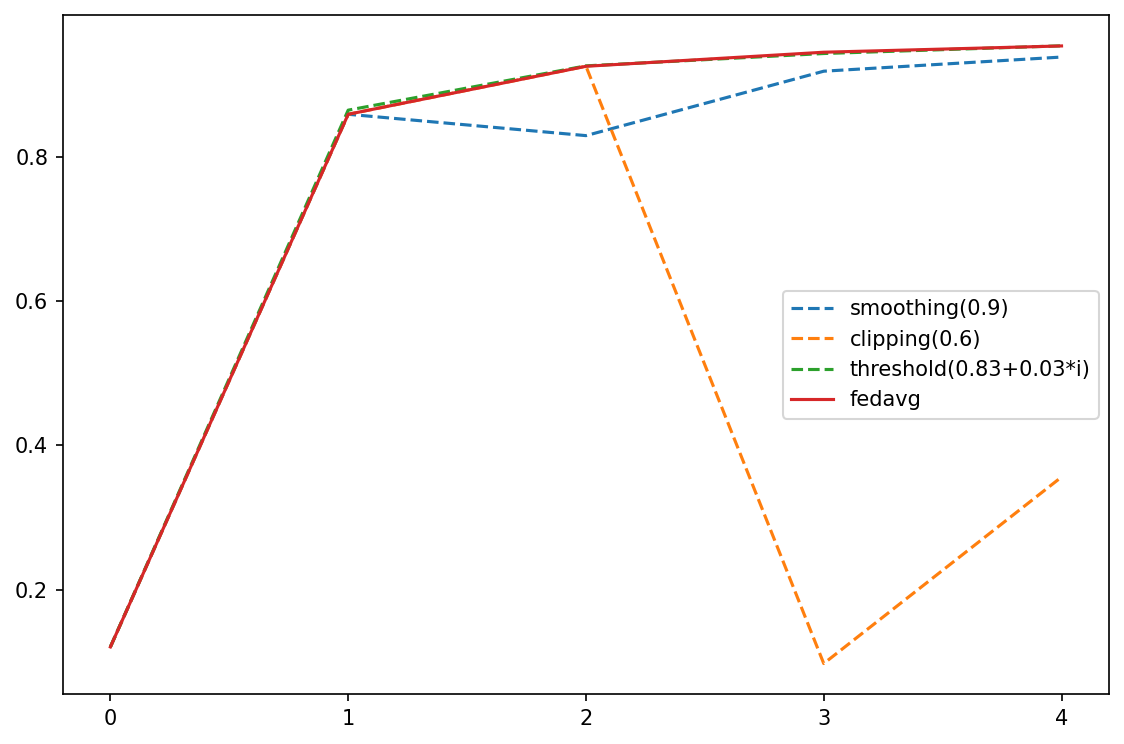

In [20]:
import matplotlib.pyplot as plt
import numpy as np

smoothing = [0.134,
0.11,
0.11,
0.109,
0.11,
0.128,
0.12,
0.123,
0.127,
0.133,
0.878,
0.862,
0.847,
0.874,
0.83,
0.865,
0.846,
0.853,
0.863,
0.869,
0.834,
0.824,
0.821,
0.851,
0.825,
0.835,
0.835,
0.817,
0.823,
0.826,
0.924,
0.931,
0.906,
0.922,
0.91,
0.911,
0.915,
0.914,
0.928,
0.923,
0.946,
0.952,
0.925,
0.941,
0.936,
0.934,
0.928,
0.932,
0.944,
0.942,]

threshold = [0.134,
0.11,
0.11,
0.109,
0.11,
0.128,
0.12,
0.123,
0.127,
0.133,
0.882,
0.862,
0.854,
0.878,
0.842,
0.866,
0.85,
0.868,
0.862,
0.88,
0.939,
0.932,
0.918,
0.937,
0.918,
0.916,
0.92,
0.921,
0.928,
0.929,
0.957,
0.953,
0.93,
0.946,
0.936,
0.934,
0.938,
0.937,
0.951,
0.947,
0.961,
0.956,
0.941,
0.954,
0.947,
0.953,
0.954,
0.955,
0.961,
0.954,]

clipping = [
    0.134,
0.11,
0.11,
0.109,
0.11,
0.128,
0.12,
0.123,
0.127,
0.133,
0.878,
0.862,
0.847,
0.874,
0.83,
0.865,
0.846,
0.853,
0.863,
0.869,
0.935,
0.933,
0.917,
0.939,
0.915,
0.913,
0.922,
0.922,
0.928,
0.929,
0.1,
0.098,
0.091,
0.097,
0.103,
0.087,
0.1,
0.094,
0.099,
0.105,
0.368,
0.34,
0.365,
0.35,
0.335,
0.355,
0.364,
0.359,
0.363,
0.36,
]

fedavg = [
    0.134,
0.11,
0.11,
0.109,
0.11,
0.128,
0.12,
0.123,
0.127,
0.133,
0.878,
0.862,
0.847,
0.874,
0.83,
0.865,
0.846,
0.853,
0.863,
0.869,
0.935,
0.933,
0.917,
0.939,
0.915,
0.912,
0.922,
0.922,
0.928,
0.929,
0.957,
0.953,
0.933,
0.948,
0.937,
0.936,
0.945,
0.938,
0.952,
0.948,
0.966,
0.956,
0.942,
0.953,
0.947,
0.949,
0.952,
0.954,
0.961,
0.954,
]
smoothing = [np.average(x) for x in np.split(np.array(smoothing), 5)]
clipping = [np.average(x) for x in np.split(np.array(clipping), 5)]
threshold = [np.average(x) for x in np.split(np.array(threshold), 5)]
fedavg = [np.average(x) for x in np.split(np.array(fedavg), 5)]

plt.figure(figsize=(9,6), dpi=150)
plt.plot(smoothing, label = 'smoothing(0.9)', linestyle='--')
plt.plot(clipping, label = 'clipping(0.6)', linestyle='--')
plt.plot(threshold, label = 'threshold(0.83+0.03*i)', linestyle='--')
plt.plot(fedavg, label = 'fedavg')

plt.legend()
plt.xticks(range(5))
plt.show()